# Genz Product Test Function

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import optuna
import pandas as pd

In [4]:
import jax
import jax.numpy as jnp
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
from jax.lib import xla_bridge

In [5]:
from ffbq.utils import grid, regrid, train_test, mse, metric_bq, sr_to_N, log_results, area
from ffbq.genz import GenzProduct
from ffbq.gp.gp import GP, LowRankGP
from ffbq.gp.kernels import RFF
from ffbq.gp.transforms import Transform, ARD
from ffbq.models import *
from ffbq.gp.training import kfold_train_test, fitgp_hparams
from ffbq.conv import *
from ffbq.sparse_conv import *

In [6]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Data and Problem Setup

In [7]:
data_key = jax.random.PRNGKey(0)

In [8]:
# problem settings
d = 2
lb, ub = 0., 1.
bounds = jnp.repeat(jnp.array([[lb, ub]]), d, axis=0).T
sr = 50

# problem and solution
genz = GenzProduct(d=d, bound=ub)
sol, sol_var = genz.solution(solver="mc", N=10000000)

# generate data
X, y, _ = genz.sample(N=2000, key=data_key)
gridX = grid(bounds, N=1000, flatten=False)
gridy = jnp.apply_along_axis(genz.f, -1, gridX)

# train/test split
X_train, X_test, y_train, y_test = train_test(data_key, X, y, test_size=0.5)

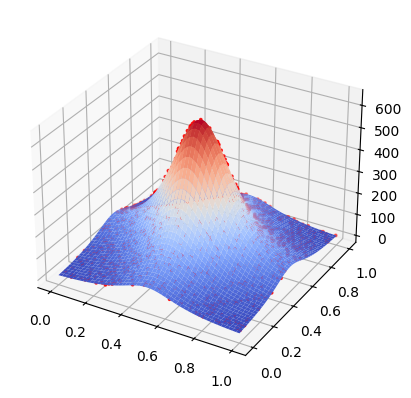

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(gridX[..., 0], gridX[..., 1], gridy, cmap=cm.coolwarm)
ax.scatter(X_train[..., 0], X_train[..., 1], y_train, c='r', marker='o', s=3)

## Hparam Opt

In [10]:
HPARAM_KEY = jax.random.PRNGKey(0)
ntrials = 30
nfolds = 5

In [11]:
diag_min, diag_max = 1e-4, 1e1
lr_min, lr_max = 1e-4, 1e-1
epoch_min, epoch_max = 100, 1000
dropout_min, dropout_max = 0.0, 0.3

search_space = {
    "rbf": {
        "lr": (lr_min, lr_max),
        "epochs": (epoch_min, 400),
    },
    "rff": {
        # "diag": (diag_min, diag_max),
        "lr": (lr_min, lr_max),
        "epochs": (epoch_min, epoch_max),
        "dropout": (dropout_min, dropout_max),
    },
    "lrgp": {
        # "diag": (diag_min, diag_max),
        "lr": (lr_min, lr_max),
        "epochs": (epoch_min, epoch_max),
        "dropout": (dropout_min, dropout_max),
    },
}

static = {
    "rbf": {
        # "epochs": 300,
        "diag": 1e-4,
        "init_ls": True,
        "kernel": "rbf"
    },
    "rff": {
        "diag": 1e-4,
        "R": 100,
        "init_ls": True
    },
    "lrgp": {
        "diag": 1e-4,
        "R": 100,
        "init_ls": True
    },
}

#### Full Rank RBF GP

Parameters will be shared with other full-rank GPs

In [15]:
rbf_study = fitgp_hparams(
    HPARAM_KEY, build_train_gp, X_train, y_train, nfolds=5, ntrials=ntrials,
    search_space=search_space["rbf"], **static["rbf"]
)

[I 2024-03-07 22:56:18,533] A new study created in memory with name: no-name-892a8e90-c4d3-4b11-85b1-6cfdeb89b997
[I 2024-03-07 22:57:00,307] Trial 0 finished with value: 0.010306312217189228 and parameters: {'lr': 0.003482209421192715, 'epochs': 300}. Best is trial 0 with value: 0.010306312217189228.
[I 2024-03-07 22:57:53,258] Trial 1 finished with value: 0.8864019048138823 and parameters: {'lr': 0.013227200813505795, 'epochs': 400}. Best is trial 0 with value: 0.010306312217189228.
[I 2024-03-07 22:58:35,100] Trial 2 finished with value: 0.002407666375311506 and parameters: {'lr': 0.00018289008572115918, 'epochs': 300}. Best is trial 2 with value: 0.002407666375311506.
[I 2024-03-07 22:59:27,987] Trial 3 finished with value: 0.0009382266945391998 and parameters: {'lr': 0.0005061557049206674, 'epochs': 400}. Best is trial 3 with value: 0.0009382266945391998.
[I 2024-03-07 22:59:59,483] Trial 4 finished with value: 33362.07767516824 and parameters: {'lr': 0.08023015232734994, 'epochs'

#### Full Rank RFF GP

In [43]:
rbf_study = fitgp_hparams(
    HPARAM_KEY, build_train_rff_gp, X_train, y_train, nfolds=5, ntrials=ntrials,
    search_space=search_space["rff"], **static["rff"]
)

[I 2024-03-08 02:57:21,511] A new study created in memory with name: no-name-2f2b372d-08f0-4bf3-8eaf-e9ccd7c4c088
[I 2024-03-08 02:58:37,087] Trial 0 finished with value: 0.8765180033185072 and parameters: {'lr': 0.00257079295594396, 'epochs': 500, 'dropout': 0.2847931043843412}. Best is trial 0 with value: 0.8765180033185072.
[I 2024-03-08 03:00:28,275] Trial 1 finished with value: 4.847149112531159 and parameters: {'lr': 0.01469183944435472, 'epochs': 800, 'dropout': 0.09681333236585012}. Best is trial 0 with value: 0.8765180033185072.
[I 2024-03-08 03:00:52,368] Trial 2 finished with value: 0.9442895746920041 and parameters: {'lr': 0.016246709578223724, 'epochs': 100, 'dropout': 0.008942875758627044}. Best is trial 0 with value: 0.8765180033185072.
[I 2024-03-08 03:01:28,890] Trial 3 finished with value: 0.9899233714944091 and parameters: {'lr': 0.000759942098932264, 'epochs': 200, 'dropout': 0.1182759394955325}. Best is trial 0 with value: 0.8765180033185072.
[I 2024-03-08 03:03:20

#### Low Rank RFF GP

In [ ]:
lrgp_study = fitgp_hparams(
    HPARAM_KEY, build_train_lrgp, X_train, y_train, nfolds=5, ntrials=ntrials, 
    search_space=search_space["lrgp"], **static["lrgp"]
)

## Define Experiment

In [10]:
# for _d in range(2, 7):
#     genz_d = GenzProduct(d=_d, bound=1.)
#     sol, sol_var = genz_d.solution(solver="mc", N=10000000 * _d)
#     print(_d, sol, sol_var)

# from ffbq.genz import genz_quad

# sols = []
# ns = [21]

# for i, _d in enumerate([6]):
#     genz_nd = GenzProduct(d=_d, bound=ub)
#     sol = genz_quad(genz_nd, ns[i])
#     sols.append([_d, sol])
#     print(_d, sol)

sols_d = {
    2: (141.67901643152453, 1.7917669907774325e-06), 3: (1686.4546574015583, 0.14078821791852195), 
    4: (20072.943407670708, 23.812862983117572), 5: (238976.81657662528, 4062.0853245570747), 
    6: (2843827.6470158403, 696023.5029769238)
}

In [11]:
def experiment(exp_key, d, N, sr, params, noise=None, log=True, pow2=True, energy_bound=0.5):
    #### PARAMETERS AND SETTINGS    
    logfile = "product.pkl"
    exp_key, mc_key = jax.random.split(exp_key)
    sol = sols_d[d]
    
    #### GENERATE DATA
    genz = GenzProduct(d)
    X, y, y_noisy = genz.sample(2 * N, noise=noise, key=exp_key)
    X_train, X_test, y_train, y_test = train_test(exp_key, X, y, test_size=0.5)

    #### CONVOLUTION SETTINGS
    Nconv = jnp.prod(jnp.asarray(sr_to_N(sr, genz.bounds)))
    Nconv_mc = Nconv if Nconv < 50000 else 50000
    Nconv_lrmc = Nconv if Nconv < 500000 else 500000
    print(f'd: {d}, N: {N}, sr: {sr}, Nconv: {Nconv}')

    #### MEASURES
    mu, sigma = jnp.ones(d) * 0.5, jnp.ones(d) * 5
    mvn = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    mvn_1d = tfd.Normal(loc=mu, scale=sigma)
    mvu_1d = tfd.Uniform(low=genz.bounds[0, :], high=genz.bounds[1, :])  # uniform
    mvu = tfd.Independent(mvu_1d, reinterpreted_batch_ndims=1)

    measures = [("mvn", mvn, mvn_1d), ("mvu", mvu, mvu_1d)]

    # --------------------------------------- TRAIN GPS -------------------------------------- #
    print("Training GPs...")
    #### Full Rank RBF
    rbf_gp, rbf_gp_loss = build_train_gp(exp_key, X_train, y_train, kernel="rbf", **params["rbf"])
    print(f"RBF GP: {rbf_gp_loss[-1]}")

    #### Full Rank M32
    # m32_gp, m32_gp_loss = build_train_gp(exp_key, X_train, y_train, kernel="m32", **params["m32"])
    # print(f"M32 GP: {m32_gp_loss[-1]}")

    #### Full Rank RFF
    rff_gp, rff_gp_loss = build_train_rff_gp(exp_key, X_train, y_train, kernel="rff", **params["rff"])
    print(f"RFF GP: {rff_gp_loss[-1]}")
    
    #### Low Rank RBF

    #### Low Rank M32

    #### Low Rank RFF
    lrgp, lrgp_loss = build_train_lrgp(exp_key, X_train, y_train, **params["lrgp"])
    print(f"LR-RFF GP: {lrgp_loss[-1]}")

    #### Update GPs with testing data
    rbf_gp = eqx.tree_at(lambda t: t.X, rbf_gp, X_test)
    # m32_gp = eqx.tree_at(lambda t: t.X, m32_gp, X_test)
    rff_gp = eqx.tree_at(lambda t: t.X, rff_gp, X_test)
    lrgp = eqx.tree_at(lambda t: t.X, lrgp, X_test)
    
    # gps = [("rbf", rbf_gp, None), ("m32", m32_gp, None), ("rff", rff_gp, lrgp)]
    gps = [("rbf", rbf_gp, None), ("rff", rff_gp, lrgp)]

    # ---------------------------------------- RUN BQ ---------------------------------------- #
    diag_bq, diag_lrbq = params["bq"]["diag"], params["bq"]["diag_lr"]
    res = {
            "seed": int(exp_key[0]), "d": d, "N": N, "sr": sr, "Nconv": Nconv,
            "noise": noise, "params": params, "sol": sol, "metrics": []
    }
    
    print("Running BQ...")
    #### Vanilla BQ
    gaussian_conv = GaussianConv(mvn, bounds=genz.bounds)
    gaussian_mu, gaussian_sd = gaussian_conv(rbf_gp, y_test, key=mc_key, R=10000, diag=diag_bq)
    res["metrics"].append({
            "k": "rbf", "m": "mvn", "conv": "gaussian", "mu": gaussian_mu, "sd": gaussian_sd
        } | metric_bq(sol[0], gaussian_mu, gaussian_sd)
    )

    #### MC Integration
    mc_int_mu, mc_int_sd = y_train.mean() * area(genz.bounds), y_train.std() * area(genz.bounds) / jnp.sqrt(N)
    res["metrics"].append({
            "k": None, "m": "mc_int", "conv": None, "mu": mc_int_mu, "sd": mc_int_sd,
        } | metric_bq(sol[0], mc_int_mu, mc_int_sd)
    )

    for mname, m, m_1d in measures:
        for gpname, gp, sgp in gps:
            print(f"Running BQ with {gpname} gp and {mname} measure.")

            ######## Full Rank
            #### MC
            mc_conv = MCConv(m, bounds=genz.bounds)
            mc_mu, mc_sd = mc_conv(gp, y_test, key=mc_key, R=Nconv_mc, diag=diag_bq)
            res["metrics"].append({
                "k": gpname, "m": mname, "conv": "mc", "mu": mc_mu, "sd": mc_sd
            } | metric_bq(sol[0], mc_mu, mc_sd)
            )
            
            #### QMC
            qmc_conv = QMCConv(m, bounds=genz.bounds)
            qmc_mu, qmc_sd = qmc_conv(gp, y_test, key=mc_key, R=Nconv_mc, diag=diag_bq)
            res["metrics"].append({
                    "k": gpname, "m": mname, "conv": "qmc", "mu": qmc_mu, "sd": qmc_sd
                } | metric_bq(sol[0], qmc_mu, qmc_sd)
            )

            #### Nystrom BQ
            # TODO

            #### FFBQ
            ffbq_conv = FFTConv(m, bounds=genz.bounds)
            fft_mu, fft_sd = ffbq_conv(gp, y_train, sr=sr, diag=diag_bq, pow2=pow2, energy_bound=energy_bound)
            res["metrics"].append({
                    "k": gpname, "m": mname, "conv": "ffbq", "mu": fft_mu, "sd": fft_sd
                } | metric_bq(sol[0], fft_mu, fft_sd)
            )
            
            if sgp is not None:
                #### QMC
                lrmc_conv = SparseMCConv(m, bounds=genz.bounds)
                lrqmc_mu, lrqmc_sd = lrmc_conv(sgp, y_test, key=mc_key, R=Nconv_lrmc, diag=diag_lrbq, qmc=True)
                res["metrics"].append({
                        "k": "lr_" + gpname, "m": mname, "conv": "qmc", "mu": lrqmc_mu, "sd": lrqmc_sd
                    } | metric_bq(sol[0], lrqmc_mu, lrqmc_sd)
                )
                
                #### SSBQ
                # lrfft_conv = SparseFFTConv(m_1d, bounds=genz.bounds)
                # lrfft_mu, lrfft_sd = lrfft_conv(sgp, y_test, sr=sr, center=True)  # diag=diag_lrbq
                # res["metrics"].append({
                #         "k": "lr_" + gpname, "m": mname, "conv": "fft", "mu": lrfft_mu, "sd": lrfft_sd
                #     } | metric_bq(sol[0], lrfft_mu, lrfft_sd)
                # )

    if log:
        log_results(logfile, res)
    
    return res

In [12]:
def multi_seed_run(global_key, d, N, sr, params, noise=None, log=True, nruns=10, **kwargs):
    res = []
    run_keys = jax.random.split(global_key, nruns)
    for i in range(nruns):
        print(f"---------------------------------------- RUN {i+1} --------------------------------------- #")
        exp_res = experiment(run_keys[i], d, N, sr, params, noise=noise, log=log, **kwargs)
        res.extend(exp_res)
        exp_df = pd.DataFrame(exp_res['metrics']).sort_values('rel', ascending=True)
        print(exp_df[['k', 'm', 'conv', 'mse', 'rel']])
    return res

## Run Experiment

In [13]:
KEY = jax.random.PRNGKey(2024)
R = 100
sr_2d, sr_4d, sr_6d = 200, 30, 10

gp_params = {
    2: {
        "rbf": {'ls_init': True, 'diag': 1e-4, 'lr': 0.0010781759444349547, 'epochs': 200},
        "m32": {'ls_init': True, 'diag': 1e-4, 'lr': 0.0010781759444349547, 'epochs': 200},
        "rff": {'R': R, 'ls_init': True, 'diag': 1e-4, 'lr': 0.001793931577015024, 'epochs': 500, 'dropout': 0.1729042854667437},
        "lrgp": {
            'R': R, 'ls_init': True, 'diag': 1e-4, 
            'lr': 0.003414903762742351, 'epochs': 500, 'dropout': 0.22303095818865307
        },
        "bq": {'diag': 1e-4, 'diag_lr': 1e-4}
    },
    4: {
        "rbf": {'ls_init': True, 'diag': 1e-3, 'lr': 0.0010781759444349547, 'epochs': 400},
        "m32": {'ls_init': True, 'diag': 1e-3, 'lr': 0.0010781759444349547, 'epochs': 400},
        "rff": {'R': R, 'ls_init': True, 'diag': 1e-3, 'lr': 0.001793931577015024, 'epochs': 600, 'dropout': 0.1729042854667437},
        "lrgp": {
            'R': R, 'ls_init': True, 'diag': 1e-3, 
            'lr': 0.003414903762742351, 'epochs': 600, 'dropout': 0.22303095818865307
        },
        "bq": {'diag': 1e-4, 'diag_lr': 1e-4}
    },
    6: {
        "rbf": {'ls_init': True, 'diag': 1e-3, 'lr': 0.0010781759444349547, 'epochs': 400},
        "m32": {'ls_init': True, 'diag': 1e-3, 'lr': 0.0010781759444349547, 'epochs': 400},
        "rff": {'R': R, 'ls_init': True, 'diag': 1e-3, 'lr': 0.001793931577015024, 'epochs': 600, 'dropout': 0.1729042854667437},
        "lrgp": {
            'R': R, 'ls_init': True, 'diag': 1e-3, 
            'lr': 0.003414903762742351, 'epochs': 600, 'dropout': 0.22303095818865307
        },
        "bq": {'diag': 1e-4, 'diag_lr': 1e-4}
    },
}

In [ ]:
# run_res = experiment(KEY, d=2, N=500, sr=100, params=gp_params[2], log=False, noise=None)
multi_res_2 = multi_seed_run(KEY, d=2, N=1000, sr=sr_2d, params=gp_params[2], log=True, noise=None, nruns=10)

In [ ]:
multi_res_4 = multi_seed_run(
    KEY, d=4, N=1000, sr=sr_4d, params=gp_params[4], log=True, noise=None, nruns=10,
    pow2=False, energy_bound=0.1
)

In [ ]:
multi_res_6 = multi_seed_run(
    KEY, d=6, N=1000, sr=sr_6d, params=gp_params[6], log=True, noise=None, nruns=10,
    pow2=False, energy_bound=0.01
)

## Evaluate

In [15]:
import pandas as pd
import pickle
import numpy as np

In [16]:
res = pd.read_pickle("product.pkl")

metrics = []
for r in res:
    res_metrics = r["metrics"]
    exp_info = {"d": r["d"], "N": r["N"], "sr": r["sr"]}
    res_metrics = [rm | exp_info for rm in res_metrics]
    metrics.extend(res_metrics)

In [23]:
metrics = pd.DataFrame(metrics)
metrics[['k', 'conv']] = metrics[['k', 'conv']].fillna('NA')
metrics['rmse'] = np.sqrt(metrics['mse'])
sum_df = metrics.groupby(['k', 'm', 'conv', 'd'])['rel'].mean().reset_index().sort_values('rel', ascending=True)
sum_df_sd = metrics.groupby(['k', 'm', 'conv', 'd'])['rel'].std().reset_index()
sum_df_sd['rel_std'] = sum_df_sd['rel']
sum_df_sd = sum_df_sd.drop(columns='rel')
sum_df = sum_df.merge(sum_df_sd, on=['k', 'm', 'conv', 'd'])

In [24]:
sum_df[sum_df['d'] == 4]

,k,m,conv,d,rel,rel_std
7,lr_rff,mvn,qmc,4,0.013006,0.008662
8,lr_rff,mvu,qmc,4,0.014128,0.009163
11,rbf,mvn,qmc,4,0.042081,0.010155
12,rbf,mvn,gaussian,4,0.042109,0.010182
14,NA,mc_int,NA,4,0.042704,0.025616
15,rbf,mvn,mc,4,0.044319,0.013934
16,rbf,mvu,qmc,4,0.045114,0.010114
17,rbf,mvu,mc,4,0.047344,0.013889
18,rbf,mvn,ffbq,4,0.132438,0.074672
19,rbf,mvu,ffbq,4,0.197117,0.066690
